# Vehículo compartido

### Descripción del problema

El gobierno de una ciudad quiere implementar un sistema para promover el **car pooling** con la finalidad de disminuir los gastos de transporte de la ciudadanía y disminuir la huella de carbono. La aplicación utilizará un grafo dirigido que representa la infraestructura vial de la ciudad. Cada nodo de este grafo representa el punto de intersección de dos o más calles, una arista dirigida $(a,b)$ significa que hay una calle con dirección de $a$ a $b$. 
El sistema contempla dos tipos de personas: $A$ y $B$. Las personas tipo $A$ son aquellas que requieren un transporte y deben indicar su nodo origen y su nodo destino. Mientras que las personas tipo $B$ son aquellas que desean compartir su vehículo y deben indicar su nodo origen, su nodo destino y el número de lugares disponibles en su vehículo. La aplicación deberá determinar los grupos de personas que utilizarán un mismo vehículo, la ruta que seguirá dicho vehículo, así como los puntos de subida y bajada de las personas. Para simplificar el problema, la ruta que seguirá el vehículo será la ruta más corta desde el punto de origen de la persona $B$, dueña del vehículo, hasta el punto final. Los objetivos de la aplicación son:

1. **Minimizar la suma de las distancias que tienen que recorrer las personas tipo $A$**. 

La distancia recorrida por una *persona tipo $A$ asignada a un vehículo* contempla la distancia recorrida para abordar el vehículo en algún nodo de su ruta, la distancia desde el nodo de bajada hasta el destino final y la distancia recorrida en el vehículo. 

La distancia que recorre una *persona tipo $A$ que no tiene asignado un vehículo* es igual a la distancia de la ruta más corta entre su punto de origen y su punto destino.

    
2. **Minimizar el número de personas que no tienen asignado un grupo**.


Dado que la velocidad promedio de una persona caminando es de aproximadamente $4$ km/h y la velocidad promedio de un automóvil en una ciudad como la Ciudad de México es de $14$ km/h\footnote{CDMX es la cuarta ciudad más lenta del mundo y la primera a nivel nacional, El Universal, Septiembre 27, 2019, URL: https://www.eluniversal.com.mx/autopistas/cdmx-es-la-cuarta-ciudad-mas-lenta-del-mundo-y-la-primera-nivel-nacional/}, las distancias que recorran las personas sin el uso de un automóvil serán ponderadas por un factor igual a $3.5$.


### Parámetros de entrada

|| Descripción |
| :--- | :--- | 
| $G=(V,E)$ | Grafo vial | 
| $K_A$ | Número de personas tipo $A$ |
| $K_B$ | Número de personas tipo $B$ |
| $ A = \{ a_i \}$ | Conjunto de pares ordenados $a_i = (o_{a_i}, d_{a_i})$ que representan el nodo origen y nodo destino de las personas tipo $A$, donde $0 \le i < K_A$ |
| $B = \{ b_i \}$ | Conjunto de 3-tuplas $b_i = (o_{b_i}, d_{b_i}, c_{b_i})$ que representan el nodo origen, el nodo destino y la capacidad de las personas tipo $B$, donde $0 \le i < K_B$|

### Variables
|| Descripción |
| :--- | :--- | 
| $G_A = [ g_{a_0}, \cdots, g_{a_{K_A - 1}} ]$ | Etiquetas de los grupos asignados a las personas tipo $A$, $g_{a_i}$ es el grupo asignado a la persona $i$ de tipo $A$. $g_{a_i} = -1$ significa que la persona $a_i$ no tiene asignado un grupo |
| $G_B = [ g_{b_0}, \cdots, g_{b_{K_B - 1}} ]$ | Etiquetas de los grupos asignados a las personas tipo $B$, $g_{b_i}$ es el grupo asignado a la persona $i$ de tipo $B$ |
| $C_k = \{ a_i \; \| \; g_{a_i} = k \}  \cup \{ b_i \; \| \; g_{b_i} = k \}$ | Conjunto de personas en el grupo $k$, con $-1 \le k < K_B $|
| $C = \{ C_{-1}, C_0, \cdots, C_{K_B-1} \}$ | Conjunto de grupos|

## Preparación del ambiente

Las bibliotecas/módulos que se van a utilizar son:
1. osmnx
2. networkx
3. numpy
4. pandas
5. matplotlib
6. pymoo

Para instalarlas usamos:

```python
!pip install osmnx
!pip install networkx
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install -U pymoo
```

In [104]:
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

Asignamos una semilla de números aleatorios para poder generar siempre la misma secuencia de números aleatorios.

In [105]:
np.random.seed(0)

## Obtención de datos

### Instancia de prueba 1: VC-instancia-1

Para generar instancias del problema, vamos a utilizar el módulo <b>osmnx</b> para obtener el grafo de las calles de **Ciudad Jardín, Córdoba, España** considerando que la movilidad será a través de un automóvil. Dicho grafo cuenta con $112$ intersecciones entre calles.

In [106]:
Graph = ox.graph_from_place('Ciudad Jardín, Córdoba, Spain', network_type="drive")
print("Número de nodos:", len(Graph.nodes))

Número de nodos: 112


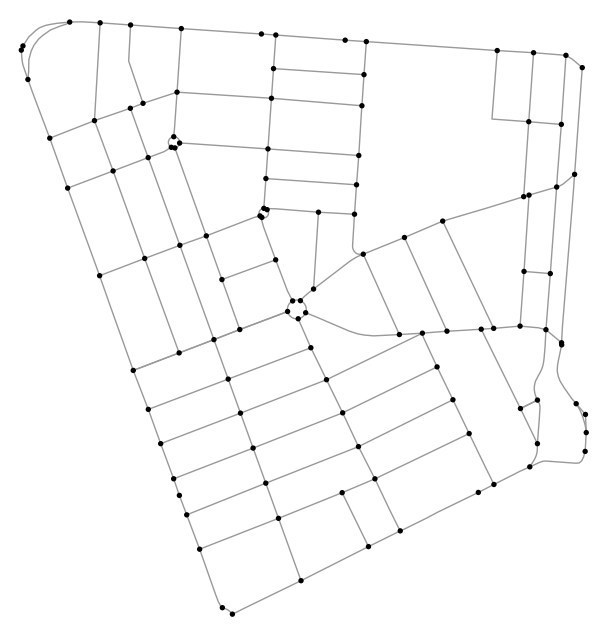

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [107]:
ox.plot_graph(Graph, bgcolor="w", node_color="black")

Para esta instancia vamos a generar $10$ personas tipo $A$ y $3$ personas tipo $B$ seleccionando aleatoriamente el nodo origen y destino de cada una.

In [108]:
K_A = 10
A = np.random.choice(Graph.nodes,(K_A,2))
print("Identificadores de los nodos:\n", A)

Identificadores de los nodos:
 [[ 330001516  330001519]
 [ 330004224  330004259]
 [ 330004259 4119801564]
 [ 329999809  408608730]
 [ 330000034  330001346]
 [ 409738622  330004374]
 [ 409738623  409738623]
 [ 329999856  330003830]
 [ 330004226 4119801563]
 [ 330001350  409738622]]


In [109]:
K_B = 3
B = np.random.choice(Graph.nodes,(K_B,2))
print("Identificadores de los nodos:\n", B)

Identificadores de los nodos:
 [[330001518 409738623]
 [408608727 330001348]
 [330000061 404247466]]


Para visualizar las coordenadas geográficas de los nodos definimos la siguiente función:

In [110]:
def print_coordinates(n, Graph):
    print("( longitud: ", Graph.nodes[n]['x'], ", " + "latitud: ", Graph.nodes[n]['y'], ")")

Nodo origen de la persona $a_0$:

In [111]:
print_coordinates(A[0][0], Graph)

( longitud:  -4.7895508 , latitud:  37.8851172 )


Nodo destino de la persona $a_1$:

In [112]:
print_coordinates(A[0][1], Graph)

( longitud:  -4.7863348 , latitud:  37.8849424 )


Las capacidades de los vehículos de las personas tipo $B$ se eligen de forma aleatoria seleccionando un número entre $1$ y $4$.

In [113]:
B = [list(i)+[np.random.randint(1,4)] for i in B]
B

[[330001518, 409738623, 1],
 [408608727, 330001348, 2],
 [330000061, 404247466, 1]]

Para generar los caminos que recorrerán las personas tipo $B$ vamos a utilizar el módulo **networkx** y la función **shortest_path**, la cual cálcula el camino más corto utilizando el algoritmo de **dijkstra**, indicando que el peso de las aristas será la distancia entre un nodo y otro.

In [114]:
B_routes = [nx.shortest_path(Graph, b[0], b[1], weight="distance") for b in B]

A continuación se muestran los caminos dentro del grafo.

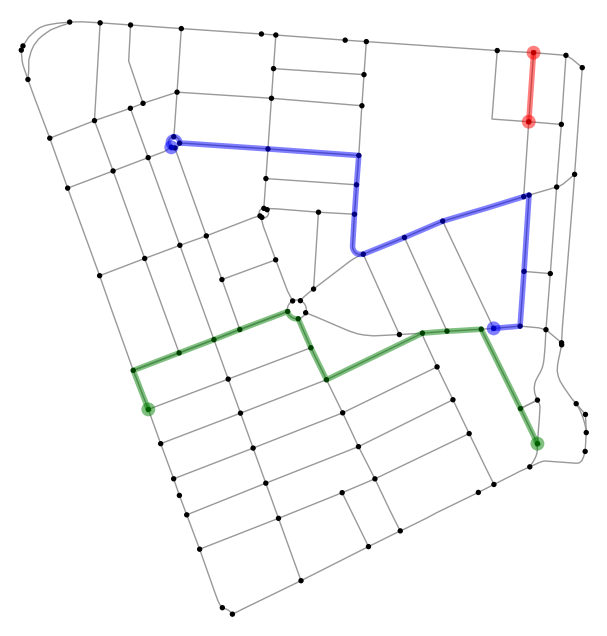

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [115]:
ox.plot.plot_graph_routes(Graph, B_routes, ['r', 'b', 'g'], bgcolor="w", node_color="black")

Para organizar los parámetros de entrada creamos dos clases **UserA** y **UserB**. En el caso de una persona tipo $A$ almacenamos su nodo de origen, su nodo destino y la distancia que recorrería si no fuese asignado a un vehículo. Para esto último utilizamos la función **shortest_path_length** del módulo **networkx**. Además creamos tres diccionarios, el primero nos permite almacenar tanto el nodo más cercano de la ruta de una persona $B$ al nodo origen de la persona $A$ como la distancia entre ambos nodos. El segundo nos permite almacenar los mismos datos pero considerando la distancia desde los nodos de la ruta de la persona $B$ hacia el nodo destino de la persona $A$. Finalmente, el tercer diccionario nos permite almacenar la distancia recorrida por la persona $A$ mientras está abordo del vehículo asignado. Estos diccionarios se irán llenando conforme la información sea requerida por los algoritmos de búsqueda.

In [116]:
class UserA:
    def __init__(self, a, Graph):
        self.source = a[0]
        self.target = a[1]
        self.independent_distance = nx.shortest_path_length(Graph, self.source, self.target, weight="distance")
        self.distanceToB = {}
        self.distanceFromB = {}
        self.sharedDistanceWithB = {}
    
    def __repr__(self):
        mystr = "\nOrigen: " + str(self.source) + "\nDestino: " + str(self.target)
        mystr += "\nDistancia del camino más corto: " + str(self.independent_distance) 
        mystr += "\nDistancias hacia los usuarios B: "
        for k, v in self.distanceToB.items():
            mystr += "\n\tb_" + str(k) + ": " + str(v[0]) + ", " + str(v[1])
        mystr += "\nDistancias desde los usuarios B: "
        for k, v in self.distanceFromB.items():
            mystr += "\n\tb_" + str(k) + ": " + str(v[0]) + ", " + str(v[1])
        mystr += "\nDistancia compartida con los usuarios B: "
        for k, v in self.sharedDistanceWithB.items():
            mystr += "\n\tb_" + str(k) + ": " + str(v[0]) + ", " + str(v[1])
            
        return mystr

En el caso de una persona tipo $B$ almacenamos su etiqueta de grupo, su nodo de origen, su nodo destino, su capacidad y la ruta que va a seguir el vehículo.

In [117]:
class UserB:
    def __init__(self, i, b, Graph):
        self.label = i
        self.source = b[0]
        self.target = b[1]
        self.capacity = b[2]
        self.path = nx.shortest_path(Graph, self.source, self.target, weight="distance")
    
    def __repr__(self):
        mystr = "\nGrupo: " + str(self.label) + "\nOrigen: " + str(self.source) + "\nDestino: " + str(self.target)
        mystr += "\nCapacidad: " + str(self.capacity) 
        mystr += "\nRuta: "        
        for node in self.path:
            mystr += " " + str(node)
            
        return mystr

A continuación creamos los objetos correspondientes a las personas tipo $A$ e imprimimos los primeros dos: $a_0$ y $a_1$.

In [118]:
def createUsersA(A, Graph):
    return [UserA(a,Graph) for a in A]

In [119]:
myUsersA = createUsersA(A, Graph)
for user in myUsersA[:2]:
    print(user)


Origen: 330001516
Destino: 330001519
Distancia del camino más corto: 3
Distancias hacia los usuarios B: 
Distancias desde los usuarios B: 
Distancia compartida con los usuarios B: 

Origen: 330004224
Destino: 330004259
Distancia del camino más corto: 3
Distancias hacia los usuarios B: 
Distancias desde los usuarios B: 
Distancia compartida con los usuarios B: 


A continuación creamos los objetos correspondientes a las personas tipo $B$ y los imprimimos.

In [120]:
def createUsersB(B, Graph):
    return [UserB(index, b, Graph) for index, b in enumerate(B)]

In [121]:
myUsersB = createUsersB(B, Graph)
for user in myUsersB:
    print(user)


Grupo: 0
Origen: 330001518
Destino: 409738623
Capacidad: 1
Ruta:  330001518 409738623

Grupo: 1
Origen: 408608727
Destino: 330001348
Capacidad: 2
Ruta:  408608727 408608730 5388004543 408608729 409738622 408608726 408608723 5401477694 330004115 330004223 330004224 329999804 330001350 330001346 330001348

Grupo: 2
Origen: 330000061
Destino: 404247466
Capacidad: 1
Ruta:  330000061 329999371 330003738 330000010 330003465 329999409 329999855 329999856 329999857 330000237 408608725 329999725 5387996982 404247466


## Definición del problema de optimización

Sea $ route(v_0, v_f) = [v_0, v_1, \cdots, v_f] \; | \; v_i \in V $ la ruta más corta para ir de un nodo origen $ v_0 $ a un nodo destino $v_f$, $dist(v_0, v_f)$ la distancia de la ruta más corta entre el nodo $v_0$ y el nodo $v_f$, $nn_1(v, r)$ el nodo más cercano de la ruta $r$ al nodo origen $v$, $nn_2(r, v)$  el nodo más cercano de la ruta $r$ al nodo destino $v$, definimos la función para calcular la suma de las distancias recorridas por los usuarios tipo $A$ de la siguiente forma:

\begin{align}
 f_1( G_A, G_B ) & = \sum_{ g_{a_i} \in G_A, g_{a_i} \ne -1 } \left( 3.5\cdot(dist(o_{a_i}, u_1) + dist(u_2, d_{a_i})) + dist(u_1, u_2) \right) \nonumber \\
 & + \sum_{g_{a_i} \in G_A, g_{a_i} = -1} 3.5 \cdot dist(o_{a_i}, d_{a_i}) 
\end{align}

donde $u_1 = nn_1(o_{a_i}, r_{b_j})$, $u_2 = nn_2(r_{b_j}, d_{a_i})$, $r_{b_j} = route(o_{b_j}, d_{b_j})$ y $g_{b_j} = g_{a_i}$. Por otro lado, definimos la cantidad de personas tipo $A$ que no tienen asignado un vehículo como sigue:

\begin{equation}
    f_2( G_A ) = \sum_{ g_{a_i} \in G_A, g_{a_i} = -1 } 1
\end{equation}

### Optimización mono-objetivo

\begin{equation}
    \min f_1(G_A, G_B)
\end{equation}

tal que para cada $b_j \in B$ se cumpla:
\begin{equation}
    g(G_A, G_B) = {\sum_{g_{a_i} \in G_A, g_{a_i} = g_{b_j}} 1} \; \; \;\le c_{b_j}
\end{equation}


### Optimización multi-objetivo

\begin{equation}
    \min F(G_A, G_B) = \left[ f_1(G_A, G_B), f_2(G_A) \right]^T
\end{equation}

tal que para cada $b_j \in B$ se cumpla:
\begin{equation}
    {\sum_{g_{a_i} \in G_A, g_{a_i} = g_{b_j}} 1} \; \; \;\le c_{b_j}
\end{equation}

### Representación de una solución

Como podemos observar en la definición del problema, nuestra tarea es asignar una etiqueta de grupo a cada persona ($A$ ó $B$). Dado que las personas tipo $B$ son aquellas que pueden prestar un vehículo para formar un grupo, tomaremos su índice como la etiqueta de su grupo y dicha etiqueta podrá ser asignada a las personas tipo $A$. Cada índice $i$ tendrá $c_{b_i}$ copias, es decir, la capacidad del vehículo de la persona $b_i$. En caso de que haya más personas $A$ que etiquetas disponibles, rellenaremos el resto con etiquetas $-1$. Por lo anterior, veremos una solución como un arreglo con las etiquetas de las personas tipo $A$, por ejemplo:

In [122]:
G_A = []
for i in range(K_B):
    G_A += myUsersB[i].capacity*[myUsersB[i].label]
remaining = K_A - len(G_A)
if remaining > 0:
    G_A += [-1]*remaining
print("G_A = ", G_A)

G_A =  [0, 1, 1, 2, -1, -1, -1, -1, -1, -1]


La solución anterior indica que la persona $a_0$ está asignada al vehículo de la persona $b_0$, mientras que las personas $a_1$ y $a_2$ están asignadas al vehículo de la persona $b_1$ y, la persona $a_3$ está asignada al vehículo del usuario $b_2$. Finalmente, las personas $a_4$, $a_5$, $a_6$, $a_7$, $a_8$ y $a_9$ no tienen asignado un vehículo. Las soluciones restantes al problema las podemos generar haciendo permutaciones de las posiciones de $G_A$, por ejemplo:

In [123]:
G_A_new = G_A.copy()
np.random.shuffle(G_A_new)
print("G_A_new = ", G_A_new)

G_A_new =  [-1, 1, -1, -1, 1, -1, -1, -1, 0, 2]


Dado que el problema indica que no es necesario llenar los vehículos cuando es menos costoso para las personas $A$ trasportarse de su origen a su destino que transportarse a los nodos de las rutas que siguen las personas tipo $B$, agregaremos valores con $-1$ a nuestra solución. En este caso agregaremos el mismo número de $-1$ que personas de tipo $A$:

In [124]:
G_A_ext = G_A + [-1]*(len(G_A)-remaining)
print("G_A_ext = ", G_A_ext)

G_A_ext =  [0, 1, 1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


<div style='text-align: justify;'>
Cuando se evalúa una solución en la función objetivo solo se van a considerar las primeras $K_A$ posiciones que son las que indican las etiquetas de las personas tipo $A$. Por lo tanto, la solución <b>G_A_Ext</b> es equivalente a la solución <b>G_A</b>. A continuación definimos una función que nos permite obtener la permutación inicial a partir de los usuarios $A$ y $B$.
<div>

In [125]:
def initial_permutation(myUsersA:list, K_A:int, myUsersB:list, K_B:int):
    permutation = []
    for i in range(K_B):
        permutation += [myUsersB[i].label]*myUsersB[i].capacity        
    permutation += [-1]*K_A
    return np.array(permutation)

In [126]:
print(initial_permutation(myUsersA, K_A, myUsersB, K_B))

[ 0  1  1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


### Generación de la solución inicial

La solución inicial será una permutación aleatoria de las etiquetas creadas en la sección anterior.

In [127]:
def get_initial_solution(myUsersA, K_A, myUsersB, K_B):
    x = initial_permutation(myUsersA, K_A, myUsersB, K_B)
    np.random.shuffle(x)
    return x

In [128]:
print(get_initial_solution(myUsersA, K_A, myUsersB, K_B))

[-1 -1 -1 -1  1 -1 -1 -1  1  0 -1 -1 -1  2]


La solución anterior indica que las personas $a_0$, $a_1$, $a_2$, $a_3$, $a_5$, $a_6$, $a_7$ no tienen asignado un vehículo, mientras que las persona $a_4$ y $a_8$ están asignadas al vehículo de la persona $b_1$ y, la persona $a_9$ está asignada el vehículo de la persona $b_0$.

### Función objetivo

A continuación definimos la función $dist$ que nos permite calcular la distancia mínima entre un nodo de origen y nodo destino.

In [129]:
def dist(source, target, Graph):
    return nx.shortest_path_length(Graph, source, target, weight="distance")

Ahora definimos la función $nn_1$ que nos permite encontrar el nodo más cercano de una ruta a un nodo de origen. Dicha función regresa tanto la distancia entre los nodos como el nodo encontrado.

In [130]:
def nn_1(source, path, Graph):    
    return min([[dist(source, node, Graph), node] for node in path])

De igual forma definimos la función $nn_2$ que nos permite encontrar el nodo más cercano de una ruta a un nodo destino.

In [131]:
def nn_2(path, target, Graph):
    return min([[dist(node, target, Graph), node] for node in path])

Nodo más cercano de la ruta de la persona $b_0$ al nodo origen de la persona $a_0$:

In [132]:
nn_1(myUsersA[0].source, myUsersB[0].path, Graph)

[2, 330001518]

Nodo más cercano de la ruta de la persona $b_0$ al nodo destino de la persona $a_0$:

In [133]:
nn_2(myUsersB[0].path, myUsersA[0].target, Graph)

[1, 330001518]

Una vez implementadas las funciones $dist$, $nn_1$ y $nn_2$ definimos la función objetivo como sigue:    

In [134]:
def f1(G_A, myUsersA, K_A, myUsersB, Graph):
    distance = 0
    for index, group in enumerate(G_A[:K_A]):
        if group == -1:
            distance += 3.5*myUsersA[index].independent_distance
        else: 
            if group not in myUsersA[index].distanceToB:
                myUsersA[index].distanceToB[group] = nn_1(myUsersA[index].source, myUsersB[group].path, Graph)
            
            if group not in myUsersA[index].distanceFromB:
                myUsersA[index].distanceFromB[group] = nn_2(myUsersB[group].path, myUsersA[index].target, Graph)
                
            if group not in myUsersA[index].sharedDistanceWithB:
                myUsersA[index].sharedDistanceWithB[group] = dist(myUsersA[index].distanceToB[group][1], myUsersA[index].distanceFromB[group][1], Graph)

            distance += 3.5*(myUsersA[index].distanceToB[group][0] + myUsersA[index].distanceFromB[group][0]) + myUsersA[index].sharedDistanceWithB[group]
    return distance    

Calculamos el valor de la función objetivo para la solución **G_A_ext**.

In [135]:
print("f1(", G_A_ext, ") = ", f1(G_A_ext, myUsersA, K_A, myUsersB, Graph))

f1( [0, 1, 1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] ) =  202.0


### Grupos creados

Implementamos una función que nos permita agrupar las rutas de acuerdo a las etiquetas asignadas.

In [136]:
def create_groups(G_A, myUsersA, K_A, myUsersB, K_B):
    clusters = {}
    clusters[-1] = []
    for i in range(K_B):
        clusters[i] = [myUsersB[i].path]

    for i, group in enumerate(G_A):
        if group == -1:
            clusters[-1].append(nx.shortest_path(Graph, myUsersA[i].source, myUsersA[i].target, weight="distance"))
        else:
            clusters[group].append(nx.shortest_path(Graph, myUsersA[i].source, myUsersA[i].target, weight="distance"))
    return clusters

Utilizamos la solución G_A_ext para agrupar las rutas según las etiquetas asignadas.

In [137]:
best = G_A_ext[:K_A]
clusters = create_groups(best, myUsersA, K_A, myUsersB, K_B)

Creamos una función que nos permita crear $n$ colores diferentes:

In [138]:
def get_colors(n):
    keys = list(mcolors.CSS4_COLORS.keys())
    return list(np.random.choice(keys,n))

In [139]:
get_colors(3)

['peru', 'darkmagenta', 'darkseagreen']

Creamos una función que grafique las rutas de todos los usuarios de tal forma que los usuarios asignados a un mismo grupo tengan un mismo color. Las rutas coloreadas en rojo siempre pertenecen a los usuarios que no tienen asignado un vehículo.

In [140]:
def plot_clustered_routes(clusters, colors, Graph):
    aux_routes = []
    aux_colors = []
    colors.append("red")
    for k, v in clusters.items():
        for path in v:
            aux_routes.append(path)
            aux_colors.append(colors[k])
            
    ox.plot.plot_graph_routes(Graph, aux_routes, aux_colors, bgcolor="w", node_color="black")   

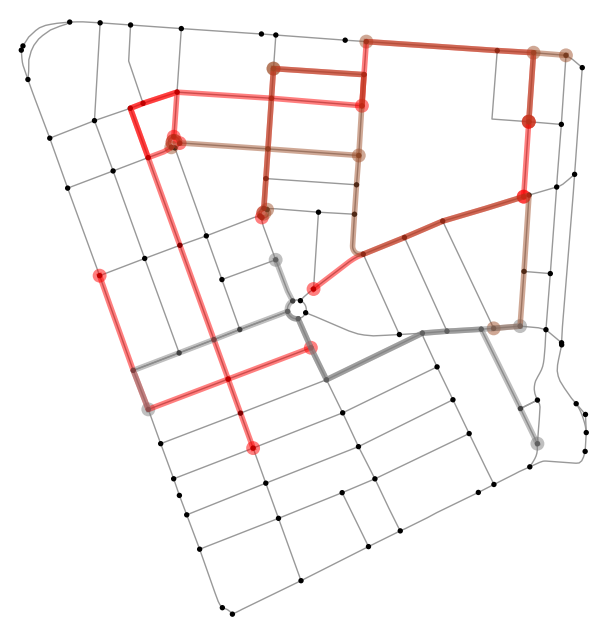

In [141]:
plot_clustered_routes(clusters, get_colors(K_B), Graph)

Creamos una función que nos permita graficar las rutas de un grupo.

In [142]:
def plot_cluster(group, clusters, Graph):
    n_routes = len(clusters[group])
    print("Número de usuarios en el grupo", group, ": ", n_routes)
    if n_routes > 1:
        ox.plot.plot_graph_routes(Graph, clusters[group], get_colors(n_routes), bgcolor="w", node_color="black")
    else:
        ox.plot.plot_graph_route(Graph, clusters[group][0], route_color="b", bgcolor="w", node_color="black") 

Usuarios $A$ que no tienen asignado un vehículo.

Número de usuarios en el grupo -1 :  6


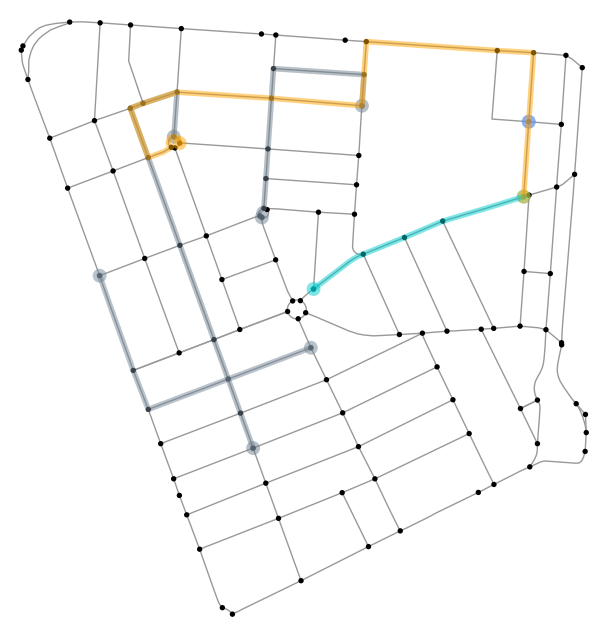

In [143]:
plot_cluster(-1, clusters, Graph)

Usuarios asignados al grupo $0$.

Número de usuarios en el grupo 0 :  2


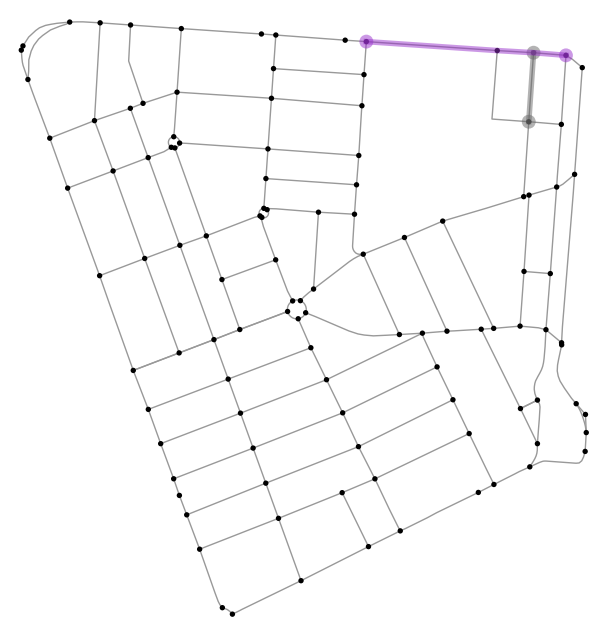

In [144]:
plot_cluster(0, clusters, Graph)

Usuarios asignados al grupo $1$.

Número de usuarios en el grupo 1 :  3


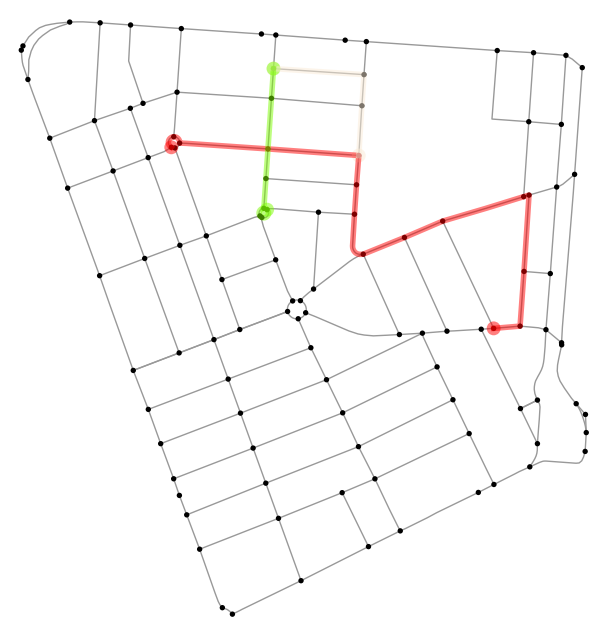

In [145]:
plot_cluster(1, clusters, Graph)

Usuarios asignados al grupo $2$.

Número de usuarios en el grupo 2 :  2


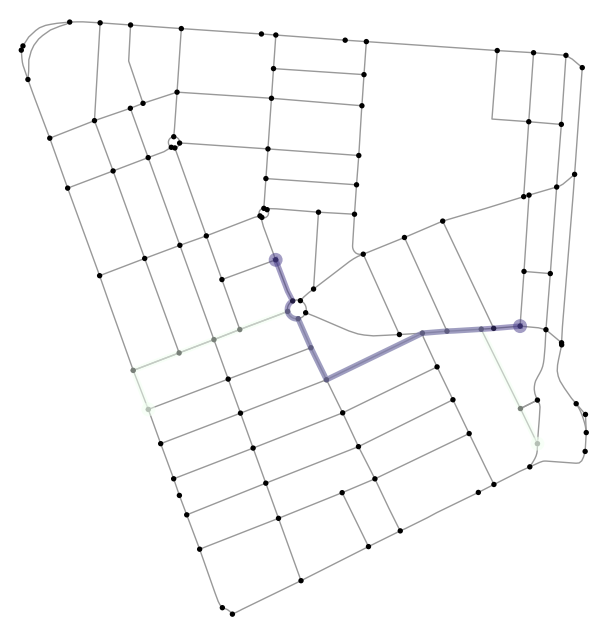

In [146]:
plot_cluster(2, clusters, Graph)

## Algoritmo Evolutivo: Caso mono-objetivo

### Representación de las soluciones

Debido a cómo trabajan los operadores de cruza y mutación para permutaciones en los AEs, veremos una solución como una permutación de los índices de una solución base. A continuación se muestra cómo crear la solución base.

In [147]:
base_solution = initial_permutation(myUsersA, K_A, myUsersB, K_B)
print(base_solution, type(base_solution))

[ 0  1  1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] <class 'numpy.ndarray'>


Cada individuo será una instancia de la siguiente clase:

In [148]:
class Individual:
    global base_solution
    
    def __init__(self, f, permutation, myUsersA, K_A, myUsersB, Graph):
        self.permutation = permutation.copy()
        self.labels = base_solution[permutation][:K_A]
        self.f = f(self.labels, myUsersA, K_A, myUsersB, Graph)
        
    def __repr__(self):
        mystr = "\nIndexes: " + str(self.permutation)
        mystr += "\nG_A: " + str(self.labels)
        mystr += "\nf: " + str(self.f)
        return mystr
    
    def __lt__(self, other):
        if self.f < other.f:
            return True
        return False
        

Donde $permutation$ es una permutación de las posiciones del arreglo, $labels$ son las etiquetas asignadas dada la permutación de las posiciones y la solución base, y $f$ es el valor en la función objetivo.

In [149]:
np.random.seed(0)
indexes = np.array([i for i in range(len(base_solution))])
print(indexes)
np.random.shuffle(indexes)
print(indexes)
x = Individual(f1, indexes, myUsersA, K_A, myUsersB, Graph)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 8  6  4 11  2 13  9  1  7 10  3  0  5 12]


In [150]:
np.random.shuffle(indexes)
print(indexes)
y = Individual(f1, indexes, myUsersA, K_A, myUsersB, Graph)

[13  4 11  2  0  8 10 12  1  9  6  3  5  7]


In [151]:
print("Solución x: ", x)
print("Solución y: ", y)

Solución x:  
Indexes: [ 8  6  4 11  2 13  9  1  7 10  3  0  5 12]
G_A: [-1 -1 -1 -1  1 -1 -1  1 -1 -1]
f: 239.0
Solución y:  
Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1 -1  1  0 -1 -1 -1  1 -1]
f: 270.5


### Población inicial

La siguiente función nos permite crear una población de $n$ soluciones.

In [152]:
def get_initial_population(n, f, myUsersA, K_A, myUsersB, Graph):
    pop = []
    indexes = np.array([i for i in range(len(base_solution))])
    
    for _ in range(n):
        np.random.shuffle(indexes)
        pop.append(Individual(f, indexes, myUsersA, K_A, myUsersB, Graph))
    
    return pop

In [153]:
pop = get_initial_population(3, f1, myUsersA, K_A, myUsersB, Graph)
for e in pop:
    print(e)


Indexes: [11  1  7 13  2 12  6  5 10  0  3  4  9  8]
G_A: [-1  1 -1 -1  1 -1 -1 -1 -1  0]
f: 207.5

Indexes: [ 4  6  2 12  7  0  3 10  1 11  5  9  8 13]
G_A: [-1 -1  1 -1 -1  0  2 -1  1 -1]
f: 320.5

Indexes: [ 9 12  3  6  1 11  8  0  7  5  4 13 10  2]
G_A: [-1 -1  2 -1  1 -1 -1  0 -1 -1]
f: 314.5


Dado que en el método **lt** de la clase **Individual** indicamos que los objetos de esta clase se comparan a través de su atributo $f$, podemos ordenar la población con respecto al valor de la función objetivo de la siguiente forma:

In [154]:
pop.sort()
for e in pop:
    print(e)


Indexes: [11  1  7 13  2 12  6  5 10  0  3  4  9  8]
G_A: [-1  1 -1 -1  1 -1 -1 -1 -1  0]
f: 207.5

Indexes: [ 9 12  3  6  1 11  8  0  7  5  4 13 10  2]
G_A: [-1 -1  2 -1  1 -1 -1  0 -1 -1]
f: 314.5

Indexes: [ 4  6  2 12  7  0  3 10  1 11  5  9  8 13]
G_A: [-1 -1  1 -1 -1  0  2 -1  1 -1]
f: 320.5


### Operador de cruza

In [155]:
def position_based_crossover(p1, p2, n):
    size = len(p1) 
    random_positions = np.random.choice(size, n, replace=False)
   
    h1 = np.array([-1]*size)
    h1[random_positions] = p1[random_positions]
    copied_elements = p1[random_positions]
    
    index_p = 0
    index_h = 0
    
    while index_p < size and index_h < size:
        if(p2[index_p] not in copied_elements):
            if(h1[index_h] == -1):
                h1[index_h] = p2[index_p]
                index_p += 1
            index_h += 1
        else:
            index_p += 1                        
    
    return h1
    

In [156]:
print("x:", x)
print("y:", y)
h = position_based_crossover(x.permutation, y.permutation, 8)
print(h)

x: 
Indexes: [ 8  6  4 11  2 13  9  1  7 10  3  0  5 12]
G_A: [-1 -1 -1 -1  1 -1 -1  1 -1 -1]
f: 239.0
y: 
Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1 -1  1  0 -1 -1 -1  1 -1]
f: 270.5
[ 8 12  4 11  2 13  9  1  6 10  3  0  5  7]


### Operador de mutación

In [157]:
def mutation(p, n):
    new_p = p.copy()
    for _ in range(n):
        positions = np.random.choice(len(G_A), 2, replace=False)
        new_p[positions[0]], new_p[positions[1]] = new_p[positions[1]], new_p[positions[0]]

    return new_p

In [158]:
mutation(h,1)

array([ 8, 12,  4, 11,  2, 13,  1,  9,  6, 10,  3,  0,  5,  7])

### Selección de padres y sobrevivientes

Para este problema vamos a elegir las soluciones padres de manera aleatoria y los sobrevivientes se elegirán haciendo una selección +. Es decir, se unirán las poblaciones de padres e hijos y se seleccionarán a las mejores soluciones para pasar a la siguiente iteración.

### Algoritmo completo

In [159]:
def AE(num_generations, size_population, prob_crossover, prob_mutation, f, n_positions, n_swaps,  myUsersA, K_A, myUsersB, K_B):
    global base_solution
    base_solution = initial_permutation(myUsersA, K_A, myUsersB, K_B)
    current_pop = get_initial_population(size_population, f, myUsersA, K_A, myUsersB, Graph)
    
    for _ in range(num_generations):
        new_pop = []
        
        while len(new_pop) < size_population:
            p1, p2 = np.random.choice(size_population, 2, replace=False)
            if np.random.uniform(0,1) < prob_crossover:
                h_permutation = position_based_crossover(current_pop[p1].permutation, current_pop[p2].permutation, n_positions)
            else:
                h_permutation = current_pop[p1].permutation.copy()
                
            if np.random.uniform(0,1) < prob_mutation:
                h_permutation = mutation(h_permutation, n_swaps)
                
            
            new_pop.append(Individual(f, h_permutation, myUsersA, K_A, myUsersB, Graph))
            
        current_pop += new_pop
        current_pop.sort()
        current_pop = current_pop[:size_population]
        
    return current_pop[0].labels, current_pop[0].f

In [160]:
AE(num_generations=100, size_population=100, prob_crossover=0.9, prob_mutation=0.1, f=f1, n_positions=K_A//2, n_swaps=1,  myUsersA=myUsersA, K_A=K_A, myUsersB=myUsersB, K_B=K_B)

(array([-1, -1, -1,  2, -1,  1, -1, -1, -1,  1]), 159.5)

### Estadísticas

Evaluaremos el comportamiento de la metaheurística realizando $M$ ejecuciones con los mismos parámetros de entrada. 

In [161]:
def get_statistics_AE(M, num_generations, size_population, prob_crossover, prob_mutation, f, n_positions, n_swaps,  myUsersA, K_A, myUsersB, K_B):
    sols = []
    for _ in range(M):
        sol = AE(num_generations, size_population, prob_crossover, prob_mutation, f, n_positions, n_swaps,  myUsersA, K_A, myUsersB, K_B)
        sols.append(sol)
        
    sols.sort(key = lambda x: x[1])
    best = sols[0]
    worst = sols[-1]
    median = sols[M//2]
    fmean = np.mean([x[1] for x in sols])
    fstd = np.std([x[1] for x in sols])
    
    return best, worst, median, fmean, fstd

A continuación ejecutamos la metaheurística $20$ veces utilizando $100$ generaciones, un tamaño de población de $100$, K_A//2 posiciones fijas para el operador de cruza, un intercambio en el operador de mutación, una probabilidad de cruza de $0.9$ y una probabilidad de mutación de $0.1$.

In [162]:
M = 20
AE_results = get_statistics_AE(M, 100, 100, 0.9, 0.1, f1, K_A//2, 1, myUsersA, K_A, myUsersB, K_B)

In [163]:
results = pd.DataFrame()
results.index = ["AE"]
results["x_best"] = [AE_results[0][0]]
results["f_best"] = [AE_results[0][1]]

results["x_worst"] = [AE_results[1][0]]
results["f_worst"] = [AE_results[1][1]]

results["x_median"] = [AE_results[2][0]]
results["f_median"] = [AE_results[2][1]]

results["f_mean"] = [AE_results[3]]
results["f_std"] = [AE_results[4]]
results

,x_best,f_best,x_worst,f_worst,x_median,f_median,f_mean,f_std
AE,"[-1, -1, -1, 2, -1, 1, -1, -1, -1, 1]",159.5,"[-1, -1, -1, 2, -1, 1, -1, -1, -1, 1]",159.5,"[-1, -1, -1, 2, -1, 1, -1, -1, -1, 1]",159.5,159.5,0.0


Utilizamos la mejor solución para agrupar las rutas según las etiquetas asignadas.

In [164]:
best = AE_results[0][0]
clusters = create_groups(best, myUsersA, K_A, myUsersB, K_B)

Graficamos los grupos: Las rutas pertenecientes a un grupo tienen el mismo color.

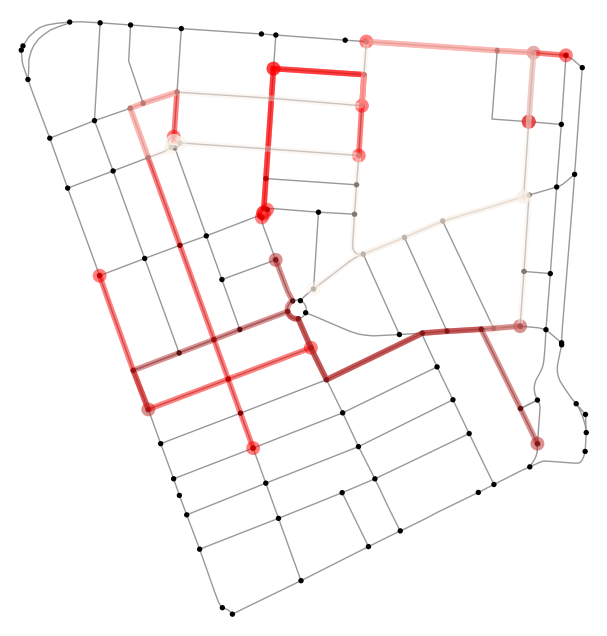

In [165]:
plot_clustered_routes(clusters, get_colors(K_B), Graph)

Usuarios $A$ que no tienen asignado un vehículo.

Número de usuarios en el grupo -1 :  7


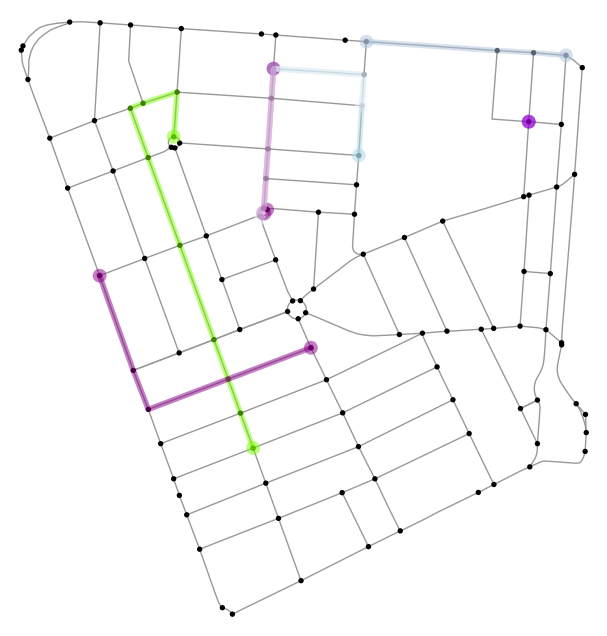

In [166]:
plot_cluster(-1, clusters, Graph)

Usuarios asignados al grupo $0$.

Número de usuarios en el grupo 0 :  1


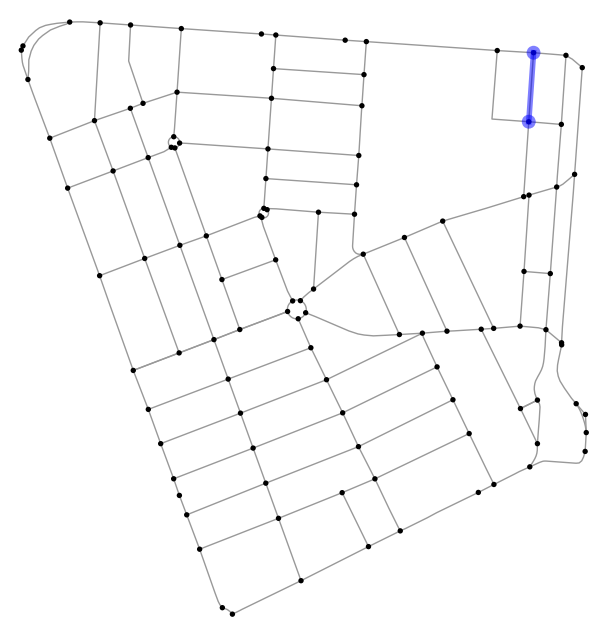

In [167]:
plot_cluster(0, clusters, Graph)

Usuarios asignados al grupo $1$.

Número de usuarios en el grupo 1 :  3


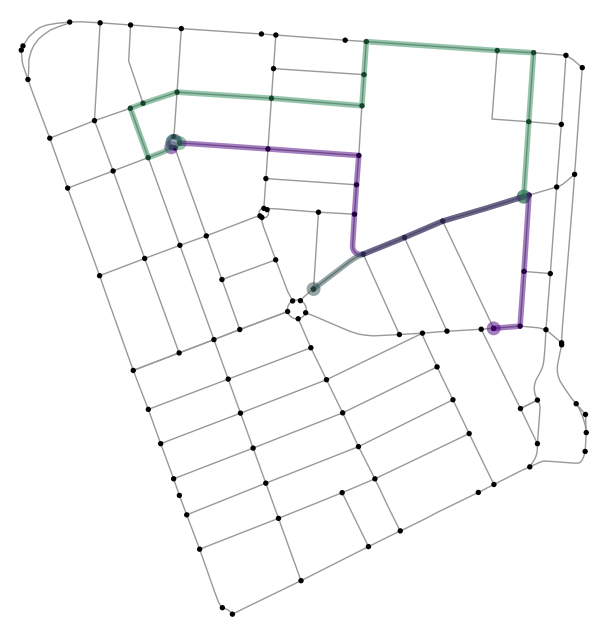

In [168]:
plot_cluster(1, clusters, Graph)

Usuarios asignados al grupo $2$.

Número de usuarios en el grupo 2 :  2


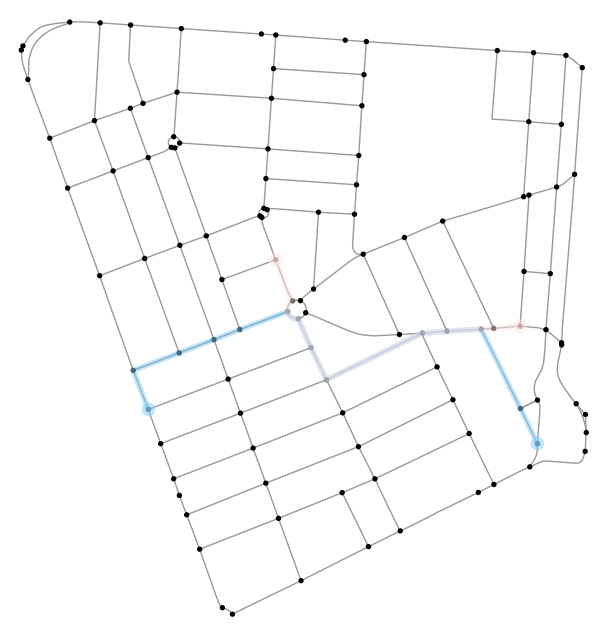

In [169]:
plot_cluster(2, clusters, Graph)

**Ejercicio 1:** Generar una nueva instancia del problema, utilizando una ciudad que tenga un mayor número de nodos, generar $100$ usuarios de tipo $A$ y $20$ usuarios de tipo $B$.

**Ejercicio 2:** Utilizar las metaheurísticas diseñadas para resolver el problema con la nueva instancia. Deberá presentar una tabla comparativa de ambas metaheurísticas considerando al menos tres conjuntos de parámetros diferentes.

**Ejercicio 3:** Graficar los grupos de la mejor solución encontrada por RS.

**Ejercicio 4:** Graficar los grupos de la mejor solución encontrada por el AE.

## Problema 2 - Optimización multi-objetivo

A continuación definimos una función que nos permite verificar la dominancia entre dos soluciones. Dicha función regresa $1$ si la solución $x$ domina a la solución $y$, $0$, si la solución $y$ domina a la solución $x$ y $-1$ si ambas soluciones son no dominadas entre sí.

In [170]:
def dominates(x: np.array, y: np.array) -> int:
    n = len(x) 
    
    #Si los puntos son iguales
    if (x==y).all():
        return -1
    
    #Si x domina a y
    if sum(x<=y) == n:
        return 1
    #Si y domina a x
    elif sum(y<=x) == n:
        return 0
    
    #Si son no dominadas entre si
    return -1

En el siguiente ejemplo las soluciones $x=[1,2]$ y $y=[2,1]$ son no dominadas entre sí porque $x$ es mejor que $y$ en la primera componente pero es peor en la segunda.

In [171]:
dominates(np.array([1,2]), np.array([2,1]))

-1

En el siguiente ejemplo las solución $x=[1,2]$ domina a la solución $y=[1,3]$ porque es mejor en ambas componentes.

In [172]:
dominates(np.array([1,2]), np.array([1,3]))

1

En el siguiente ejemplo las solución $x=[1,2]$ es dominada por la solución $y=[0.5,1]$ porque es peor en ambas componentes.

In [173]:
dominates(np.array([1,2]), np.array([1,1]))

0

## Algoritmo Evolutivo: Caso multi-objetivo

### Funciones objetivo

La función $f_1$ es la misma que se utilizó en el caso mono-objetivo. La función $f_2$ regresa la cantidad de usuarios $A$ que no tienen asignados un vehículo:

In [174]:
def f2(G_A, K_A):
    total = 0
    for i in range(K_A):
        if G_A[i] == -1:
            total += 1
    return total

A continuación definimos el problema multi-objetivo $F$:

In [175]:
def F(G_A, myUsersA, K_A, myUsersB, Graph):
    return np.array([f1(G_A, myUsersA, K_A, myUsersB, Graph), f2(G_A, K_A)])

### Representación de las soluciones

En el caso multi-objetivo utilizaremos la misma representación que en el caso mono-objetivo pero no definiremos el método __lt__ en la clase *Individual*.

In [176]:
class Individual:
    global base_solution
    
    def __init__(self, f, permutation, myUsersA, K_A, myUsersB, Graph):
        self.permutation = indexes.copy()
        self.labels = base_solution[permutation][:K_A]
        self.f = f(self.labels, myUsersA, K_A, myUsersB, Graph)
        
    def __repr__(self):
        mystr = "\nIndexes: " + str(self.permutation)
        mystr += "\nG_A: " + str(self.labels)
        mystr += "\nf: " + str(self.f)
        return mystr        

### Selección de sobrevivientes

<div style='text-align: justify;'>
A continuación implementaremos un método conocido como <b>actualización continua</b> que permite seleccionar el conjunto de soluciones no dominadas de un conjunto de soluciones. La función regresa tanto el conjunto de soluciones dominadas como el de soluciones no dominadas.
</div>

In [177]:
def get_non_dominated_solutions(P):
    non_dom = [0]
    
    for i in range(1, len(P)):
        j = 0
        i_is_non_dominated = True
        while j < len(non_dom):
            d = dominates(P[i].f, P[non_dom[j]].f)
            if d == 1:
                non_dom.pop(j)
            elif d == 0:
                i_is_non_dominated = False
                break
            else:
                j += 1
                
        if i_is_non_dominated:
            non_dom.append(i)
                           
    new_P = []
    P_i = []
    for i in range(len(P)):
        if i in non_dom:
            P_i.append(P[i])
        else:
            new_P.append(P[i])
            
    return new_P, P_i

Creamos un conjunto de soluciones:

In [178]:
np.random.seed(0)
pop = get_initial_population(5, F, myUsersA, K_A, myUsersB, Graph)
for e in pop:
    print(e)


Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1 -1 -1  1 -1 -1  1 -1 -1]
f: [239.   8.]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1 -1  1  0 -1 -1 -1  1 -1]
f: [270.5   7. ]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [ 2 -1 -1 -1 -1 -1 -1 -1 -1 -1]
f: [277.5   9. ]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [ 0 -1 -1 -1 -1 -1  1 -1 -1  2]
f: [244.   7.]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1  1 -1 -1  2  1 -1 -1 -1]
f: [262.5   7. ]


Obtenemos las soluciones dominadas y no dominadas:

In [179]:
dom, non_dom = get_non_dominated_solutions(pop)

Soluciones dominadas:

In [180]:
for e in dom:
    print(e)


Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1 -1  1  0 -1 -1 -1  1 -1]
f: [270.5   7. ]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [ 2 -1 -1 -1 -1 -1 -1 -1 -1 -1]
f: [277.5   9. ]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1  1 -1 -1  2  1 -1 -1 -1]
f: [262.5   7. ]


Soluciones no dominadas:

In [181]:
for e in non_dom:
    print(e)


Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1 -1 -1  1 -1 -1  1 -1 -1]
f: [239.   8.]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [ 0 -1 -1 -1 -1 -1  1 -1 -1  2]
f: [244.   7.]


Finalmente creamos una función que nos permita seleccionar $m$ soluciones de un conjunto de $n$ soluciones:

In [182]:
def get_survivors(pop, m):
    survivors = []
    
    while len(survivors) < m:
        dom, non_dom = get_non_dominated_solutions(pop)
        if len(survivors) + len(non_dom) <= m:
            survivors += non_dom
        else:
            remaining = m - len(survivors)
            survivors += list(np.random.choice(non_dom, remaining, replace=False))
            
    return survivors

### Algoritmo completo

In [183]:
def AEMO(num_generations, size_population, prob_crossover, prob_mutation, f, n_positions, n_swaps,  myUsersA, K_A, myUsersB, K_B):
    global base_solution
    base_solution = initial_permutation(myUsersA, K_A, myUsersB, K_B)
    current_pop = get_initial_population(size_population, f, myUsersA, K_A, myUsersB, Graph)
    
    for _ in range(num_generations):
        new_pop = []
        
        while len(new_pop) < size_population:
            p1, p2 = np.random.choice(size_population, 2, replace=False)
            if np.random.uniform(0,1) < prob_crossover:
                h_permutation = position_based_crossover(current_pop[p1].permutation, current_pop[p2].permutation, n_positions)
                if np.random.uniform(0,1) < prob_mutation:
                    h_permutation = mutation(h_permutation, n_swaps)
            else:
                h_permutation = current_pop[p1].permutation.copy()
                
            
            new_pop.append(Individual(f, h_permutation, myUsersA, K_A, myUsersB, Graph))
            
        current_pop = get_survivors(current_pop+new_pop, size_population)
        
        
    dom, non_dom = get_non_dominated_solutions(current_pop)
    return non_dom

In [184]:
aprox_Pareto = AEMO(num_generations=100, size_population=100, prob_crossover=0.9, prob_mutation=0.1, f=F, n_positions=K_A//2, n_swaps=1,  myUsersA=myUsersA, K_A=K_A, myUsersB=myUsersB, K_B=K_B)

In [185]:
for e in aprox_Pareto[:5]:
    print(e)


Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [ 0 -1 -1 -1  2 -1 -1 -1 -1  1]
f: [183.5   7. ]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1  1  2 -1 -1 -1 -1  1  0]
f: [199.5   6. ]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1 -1  2 -1 -1 -1 -1 -1  1]
f: [167.   8.]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [ 0 -1 -1 -1  2 -1 -1 -1 -1  1]
f: [183.5   7. ]

Indexes: [13  4 11  2  0  8 10 12  1  9  6  3  5  7]
G_A: [-1 -1  1  2 -1 -1 -1 -1  1  0]
f: [199.5   6. ]


### Gráfica de la aproximación del frente de Pareto

Para graficar la aproximación del frente de Pareto extraemos los vectores objetivo de una población.

In [186]:
def get_objective_values(pop):
    return np.array([e.f for e in pop])

La siguiente función genera la gráfica del frente de Pareto.

In [187]:
def plot_pareto_front(PF:np.array, alg:str):
    plt.scatter(PF[:,0],PF[:,1])
    plt.title(f"Aproximación del frente de Pareto con {alg}")
    plt.xlabel("F1")
    plt.ylabel("F2")
    plt.show()

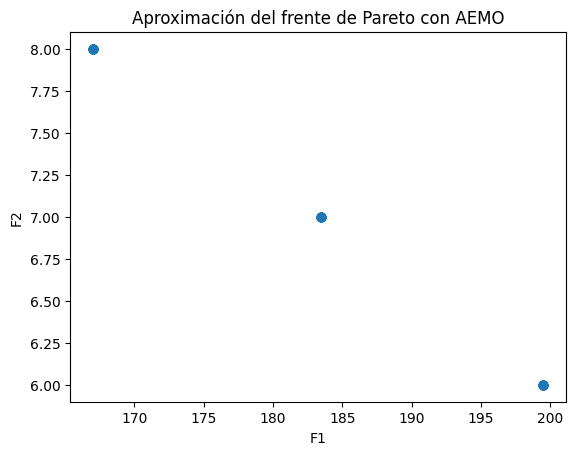

In [189]:
PF = get_objective_values(aprox_Pareto)
plot_pareto_front(PF, "AEMO")

### Indicador de hipervolumen

Con la siguiente instrucción, importamos el indicador de hipervolumen que está implementado en el módulo **pymoo**.

In [190]:
from pymoo.indicators.hv import HV

Generamos una solución que sea dominada por todas las soluciones del frente de Pareto:

In [191]:
reference_point = np.amax(PF, axis=0)+0.1
reference_point

array([199.6,   8.1])

Creamos un objeto de tipo *HV* que utiliza como punto de referencia el punto creado *reference_point*:

In [192]:
indicator = HV(ref_point = reference_point)

Finalmente, calculamos el valor del hipervolumen para el frente de Pareto encontrado:

In [193]:
print("Hypervolume: ", indicator(PF))


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Hypervolume:  19.459999999999976


### Estadísticas

Al igual que en el caso mono-objetivo, evaluaremos el comportamiento de la metaheurística realizando $M$ ejecuciones con los mismos parámetros de entrada. Para evaluar cada ejecución se utilizará el indicador de hipervolumen y el punto de referencia debe ser dominado por todos los puntos de los frentes encontrados en cada ejecución. 

In [194]:
def get_reference_point(PFs):
    ref_points = []
    for pf in PFs:
        ref_points.append(np.amax(PF, axis=0))
    ref_points = np.array(ref_points)
    
    return np.amax(ref_points, axis=0)+0.1

In [195]:
def get_statistics_AEMO(M, num_generations, size_population, prob_crossover, prob_mutation, f, n_positions, n_swaps,  myUsersA, K_A, myUsersB, K_B):
    PFs = []
    sols = []
    for _ in range(M):
        sol = AEMO(num_generations, size_population, prob_crossover, prob_mutation, f, n_positions, n_swaps,  myUsersA, K_A, myUsersB, K_B)
        sols.append([sol])
        PF = get_objective_values(sol)
        PFs.append(PF)
        
    ref_point = get_reference_point(PFs)
    indicator = HV(ref_point = ref_point)
    for i in range(M):
        sols[i].append(indicator(PFs[i]))
        
    sols.sort(key = lambda x: x[1])
    best = sols[-1]
    worst = sols[0]
    median = sols[M//2]
    HVmean = np.mean([x[1] for x in sols])
    HVstd = np.std([x[1] for x in sols])
    
    return best, worst, median, HVmean, HVstd

A continuación ejecutamos la metaheurística $100$ veces utilizando $100$ generaciones, un tamaño de población de $100$, K_A//2 posiciones fijas para el operador de cruza, un intercambio en el operador de mutación, una probabilidad de cruza de $0.9$ y una probabilidad de mutación de $0.1$.

In [196]:
AE_results = get_statistics_AEMO(M=100, num_generations=100, size_population=100, prob_crossover=0.9, prob_mutation=0.1, f=F, n_positions=K_A//2, n_swaps=1,  myUsersA=myUsersA, K_A=K_A, myUsersB=myUsersB, K_B=K_B)

In [197]:
results = pd.DataFrame()
results.index = ["AEMO"]
results["HV_best"] = [AE_results[0][1]]
results["HV_worst"] = [AE_results[1][1]]
results["HV_median"] = [AE_results[2][1]]
results["HV_mean"] = [AE_results[3]]
results["HV_std"] = [AE_results[4]]
results

,HV_best,HV_worst,HV_median,HV_mean,HV_std
AEMO,84.21,0.26,31.96,32.7525,17.941744


Graficamos el frente de Pareto que logra obtener un mejor hipervolumen.

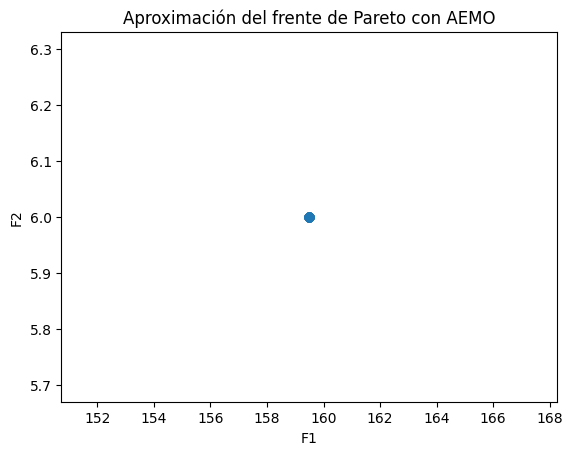

In [198]:
best_PF = get_objective_values(AE_results[0][0])
plot_pareto_front(best_PF, "AEMO")

Graficamos el frente de Pareto que logra obtener un peor hipervolumen.

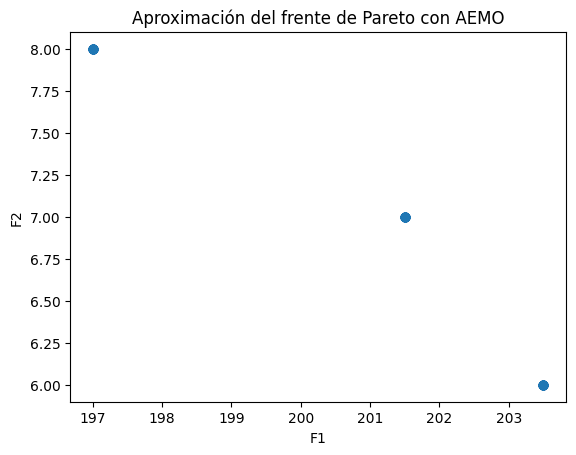

In [199]:
worst_PF = get_objective_values(AE_results[1][0])
plot_pareto_front(worst_PF, "AEMO")

Graficamos el frente de Pareto que está en la mediana, considerando el indicador de hipervolumen.

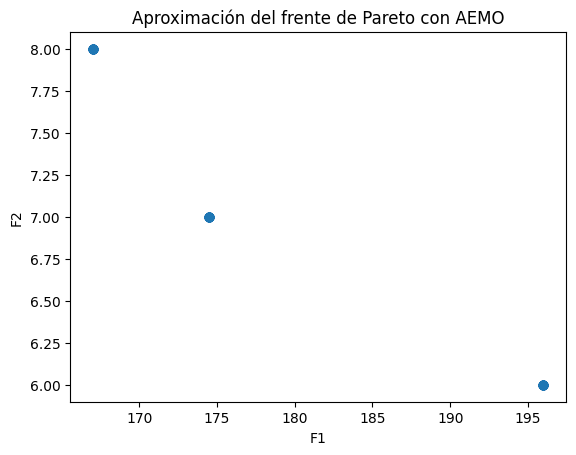

In [200]:
median_PF = get_objective_values(AE_results[2][0])
plot_pareto_front(median_PF, "AEMO")

### Grupos creados

Utilizamos el frente de Pareto correspondiente al mejor valor en el indicador de hipervolumen y buscamos la solución del frente que logra dejar la mejor cantidad de usuarios tipo $A$ sin vehículo.

In [201]:
index = np.argmin(best_PF[:,1])

Obtenemos los grupos:

In [202]:
G_A = aprox_Pareto[index].labels
clusters = create_groups(G_A, myUsersA, K_A, myUsersB, K_B)

Graficamos los grupos: Las rutas pertenecientes a un grupo tienen el mismo color. Las rutas de los usuarios a los que no se les asignó un vehículo están de color rojo.

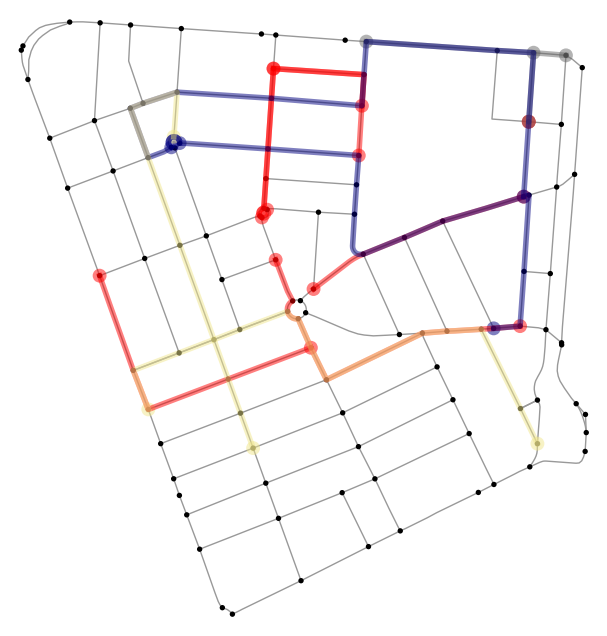

In [203]:
plot_clustered_routes(clusters, get_colors(K_B), Graph)

Usuarios $A$ que no tienen asignado un vehículo.

Número de usuarios en el grupo -1 :  7


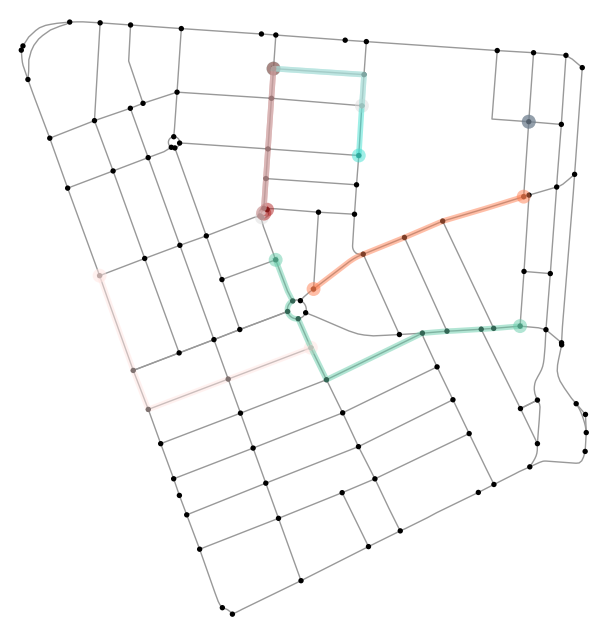

In [204]:
plot_cluster(-1, clusters, Graph)

Usuarios asignados al grupo $0$.

Número de usuarios en el grupo 0 :  2


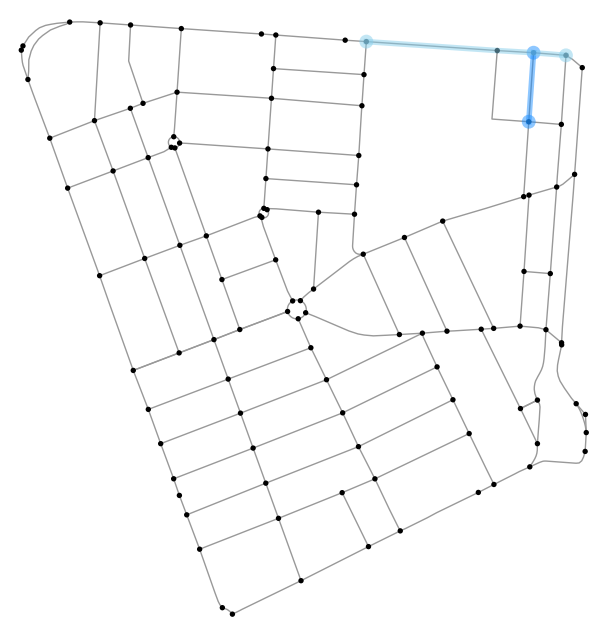

In [205]:
plot_cluster(0, clusters, Graph)

Usuarios asignados al grupo $1$.

Número de usuarios en el grupo 1 :  2


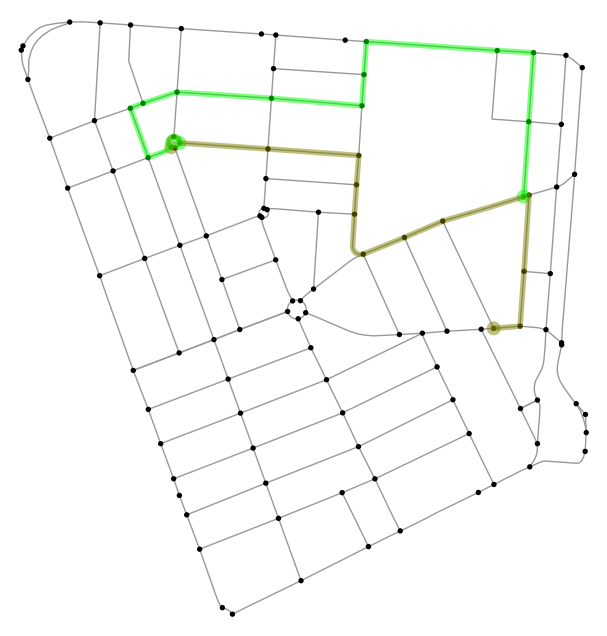

In [206]:
plot_cluster(1, clusters, Graph)

Usuarios asignados al grupo $2$.

Número de usuarios en el grupo 2 :  2


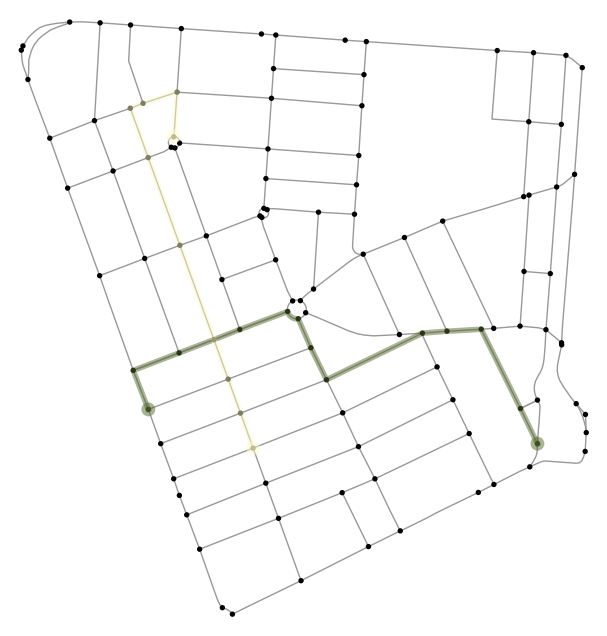

In [207]:
plot_cluster(2, clusters, Graph)

**Ejercicio 5:** Resolver la instancia generada en el *ejercicio 1* con el algoritmo evolutivo multi-objetivo propuesto. Se debe hacer un estudio estadístico, graficar el frente de Pareto correspondiente al mejor valor de hipervolumen y las agrupaciones generadas por las soluciones que puedan ser interesantes para el tomador de decisiones.

**Ejercicio 6:** Combinar la técnica de jerarquización de Pareto con una técnica que mantenga diversidad en las soluciones a lo largo del frente de Pareto. Utilizar dicha combinación en el algoritmo evolutivo diseñado y usarlo para resolver la instancia generada en el *ejercicio 1*. Se debe graficar el frente de Pareto obtenido y las agrupaciones generadas por las soluciones que puedan ser interesantes para el tomador de decisiones.

**Ejercicio 7:** Utilizar una técnica de cruza diferente y resolver la instancia del *ejercicio 1*. Se debe graficar el frente de Pareto obtenido y las agrupaciones generadas por las soluciones que puedan ser interesantes para el tomador de decisiones.